# # Homework 2: Unsupervised representation learning

# Download data, install packages

In [1]:
# !wget https://github.com/jertubiana/jertubiana.github.io/raw/master/misc/MLCB_2023_HW2_Data.pkl.zip
# !unzip MLCB_2023_HW2_Data.pkl.zip
# !pip install "ipyvolume>=0.6.2" "ipyvue>=1.9.1"
# !pip install plotly

# ## Load packages, load data

In [103]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import zipfile
import os

path = 'MLCB_2023_HW2_Data.pkl'
env = pickle.load(open(path, 'rb'))
# Spikes, Time, Coordinates, Regions, Region_names = env['Spikes'], env['Time'], env['Coordinates'], env['Regions'], env[
#     'Region names']

Region_names = env['Region names']

# ## Visualize a short section of the recording as raster plot

Text(0.5, 1.0, 'Spike raster plot')

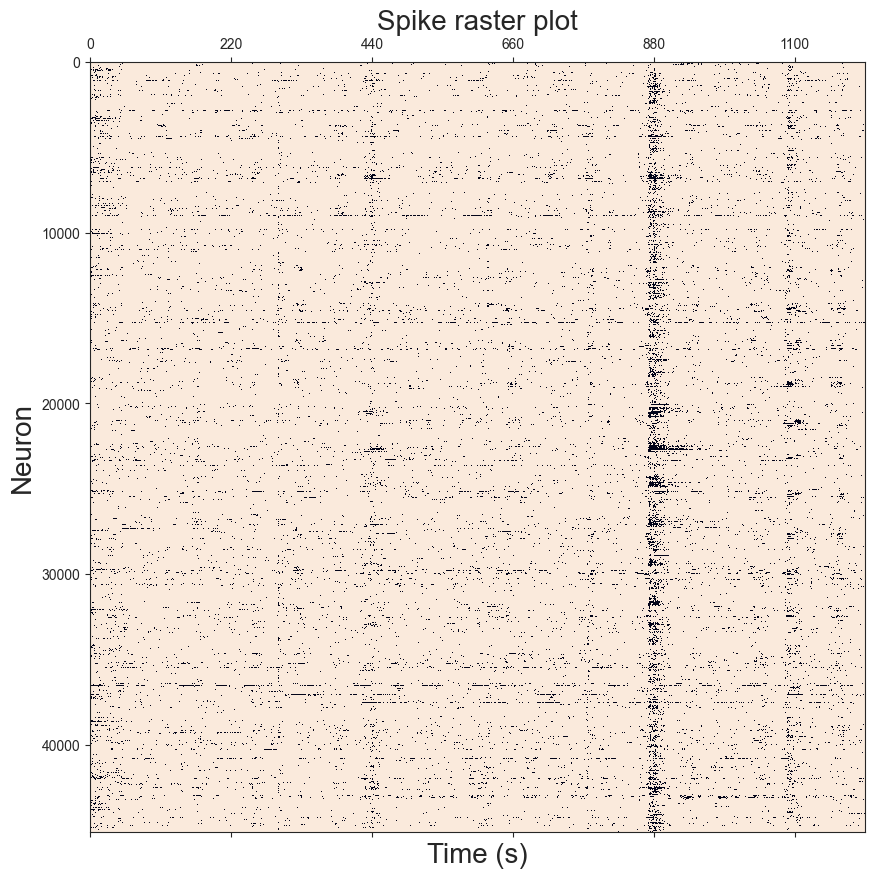

In [88]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.set_style("ticks")
ax.matshow(1 - env['Spikes'].T, aspect='auto')
plt.xticks(np.arange(len(env['Time']))[::1000], ['%.f' % t for t in env['Time'][::1000]])
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Neuron', fontsize=20)
plt.title('Spike raster plot', fontsize=20)

# ## Visualize the coordinates the neurons, colored by the region labels.

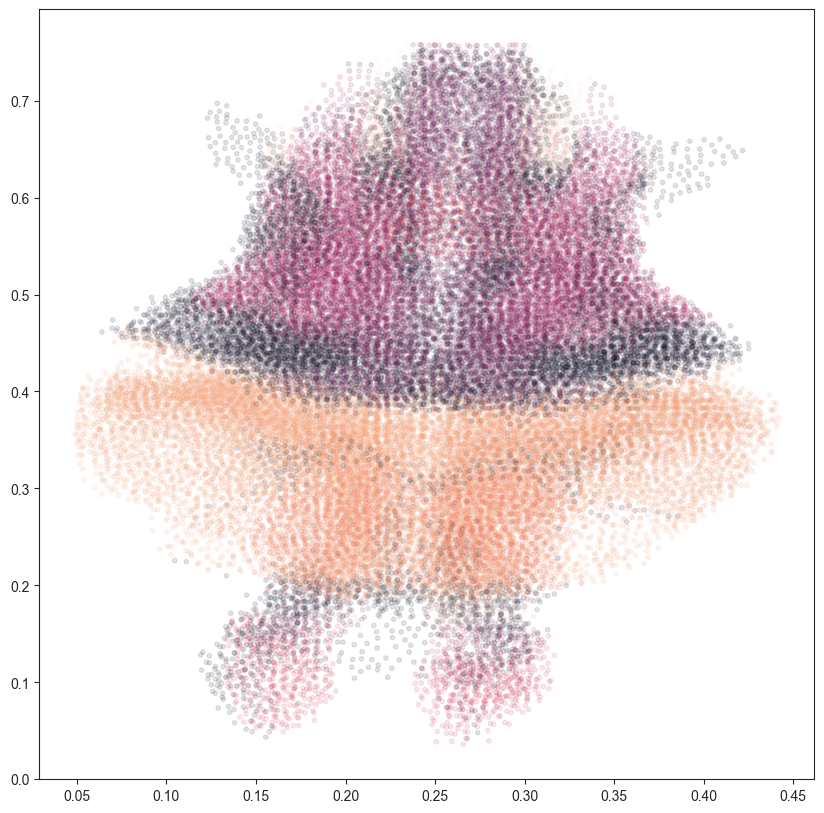

In [92]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(env['Coordinates'][:, 0], env['Coordinates'][:, 1], c=env['Regions'], s=10, alpha=0.1)

# ## A 3D-visualization of the recording with ipyvolume
# This section does not run on Google Colab, but you can try it out on your local Python

In [64]:
import plotly.graph_objects as go
import numpy as np

In [94]:
# Create a scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=env['Coordinates'][:, 0],
    y=env['Coordinates'][:, 1],
    z=env['Coordinates'][:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=env['Regions'],
        opacity=0.1
    )
)])

# Set labels
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title='3D Visualization of Neurons'
)

# Show the plot
fig.show()

# ## Subsampling the dataset to speed-up the analysis

In [95]:
np.random.seed(0)
active_neurons = (env['Spikes'].mean(0) != 0)  # Remove all inactive neurons
random_subset = active_neurons & (np.random.rand(env['Spikes'].shape[-1]) < 0.1)  # Keep only 10% of the neurons.
Spikes = env['Spikes'][:, random_subset]
Coordinates = env['Coordinates'][random_subset]
Regions = env['Regions'][random_subset]


# Part II: Dataset Analysis (Representation learning) 

## Background:
Progress in functional brain imaging techniques enable the simultaneous recording of the activity of thousands of neurons simultaneously. 

An open question is how to relate the observed spontaneous activity to the underlying 
1) neuronal assemblies (sets of neurons involved in a specific task, e.g. sensory, motor or cognitive) 
1) connectome (set of synapses). 

Herein, we focus on a recording of spontaneous brain activity of a larval zebrafish. Activity was measured using genetically modified fish expressing a fluorescent calcium reporter and with light-sheet fluorescence microscopy.
 
This dataset was collected in the laboratory of Pr. Georges Debregeas (Reference: [elife](https://elifesciences.org/articles/83139)), and consists of:

1. A matrix $X_{ij}$ of binary spikes of format [Time x Neurons].
2. 3D coordinates of the neurons [Neurons x 3].
3. An integer brain region label for each neuron, assigned based on the morphology $ M_i $ [Neurons,].

Our goal is to recover, in an unsupervised manner, the morphological regions from the correlation structure of the data. 
A Google Colab Notebook with package installation, dataset download and visualizations is available from: [Colab Notebook](https://colab.research.google.com/drive/1qSQelSprDyMKF_uRQ6ihDZWWnfdF7nOB?usp=sharing)

In [96]:
print(f"Spikes shape: {Spikes.shape}")
print(f"Coordinates shape: {Coordinates.shape}")
print(f"Regions shape: {Regions.shape}")

Spikes shape: (5500, 4633)
Coordinates shape: (4633, 3)
Regions shape: (4633,)


 
### Low-dimensional embeddings: PCA vs t-SNE
 
We define a custom distance metric between two neurons as one minus the absolute value of the Pearson correlation coefficient:
$$
\[ D_{ij} = 1 - \left| \frac{ \text{Cov}(X_i, X_j) }{ \sqrt{ \text{Var}(X_i) \cdot \text{Var}(X_j) } } \right| \]
$$

1. Using the scikit-learn default implementations, calculate two-dimensional embeddings $ R_{PCA/t-SNE} $ of the data using 1) PCA and 2) t-SNE with a perplexity of 5, 10, 20, 50, 100. Visualize them using scatter plots, where the points are colored by the brain region.


In [97]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Calculate the custom distance metric
from scipy.spatial.distance import pdist, squareform
import pandas as pd


In [150]:
def custom_distance(X):
    # Calculate the correlation matrix
    corr_matrix = np.corrcoef(X, rowvar=False)
    # Calculate the distance matrix based on the given formula
    distance_matrix = 1 - np.abs(corr_matrix)
    return fix_distance_matrix(distance_matrix)


def fix_distance_matrix(distance_matrix):
    # For numerical reasons, ensure the correlation matrix satisfies the properties of a valid correlation
    sym_corr_matrix = (distance_matrix + distance_matrix.T) / 2  # Ensure symmetry
    np.fill_diagonal(sym_corr_matrix, 0)  # Ensure the diagonal is zero
    return sym_corr_matrix


distance_matrix = custom_distance(Spikes)

In [132]:
distance_matrix.shape

(4633, 4633)

In [133]:
# Perform PCA
pca = PCA(n_components=2)
# we do it on the transposed matrix because sklearn expects the shape to be (n_samples, n_features)
pca_result = pca.fit_transform(Spikes.T)

# Perform t-SNE with different perplexities
tsne_results = {}
perplexities = [5, 10, 20, 50, 100]
for perplexity in perplexities:
    tsne = TSNE(n_components=2, perplexity=perplexity, metric='precomputed', init='random')
    tsne_results[perplexity] = tsne.fit_transform(distance_matrix)

In [134]:
pd.Series(Regions).value_counts()

58    754
0     716
57    712
6     174
27    169
28    163
5     161
30    158
19    156
29    117
20    100
24     99
23     97
47     93
48     91
21     83
22     81
26     79
25     76
71     60
59     54
37     49
38     48
41     45
42     44
61     43
72     41
60     34
62     34
15     27
10     17
9      17
16     14
64     11
63      6
70      4
50      3
49      2
69      1
Name: count, dtype: int64

In [135]:
top_regions_names = [Region_names[i] for i in pd.Series(Regions).value_counts().index[:10]]

ValueError: 'c' argument has 4633 elements, which is inconsistent with 'x' and 'y' with size 5500.

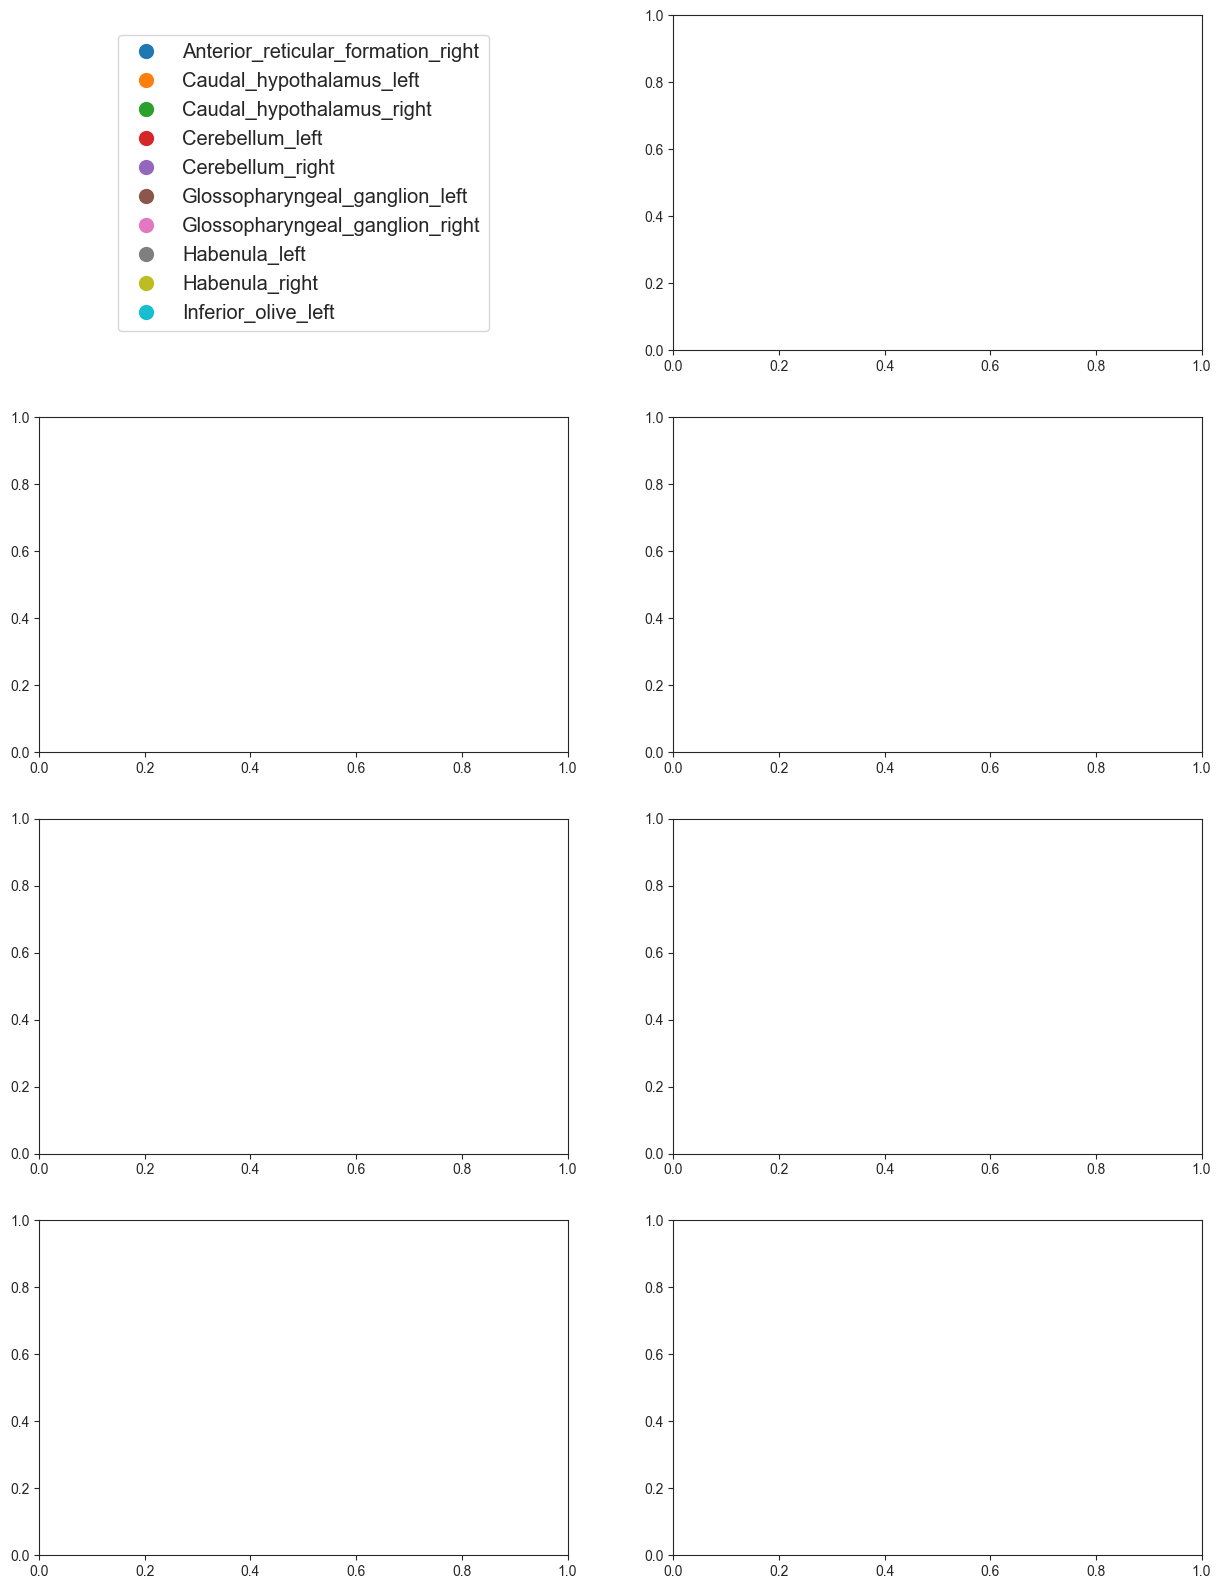

In [205]:
import matplotlib.pyplot as plt

# Define the number of rows
num_rows = (len(perplexities) + 1) // 2 + 1

# Create subplots with specified number of rows and 2 columns
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))

# Add the legend in the first row, first column with larger font size
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='C' + str(i), label=region_name) for
           i, region_name in enumerate(top_regions_names)]
legend = axes[0, 0].legend(handles, Region_names[1:], loc='center', fontsize='x-large', markerscale=2)
axes[0, 0].axis('off')  # Turn off the axis for the legend plot

# Plot PCA in the first row, second column
axes[0, 1].scatter(pca_result[:, 0], pca_result[:, 1], c=Regions, alpha=0.5)
axes[0, 1].set_title('PCA')

# Plot t-SNE results in the remaining rows
for i, perplexity in enumerate(perplexities):
    row = i // 2 + 1  # Calculate the row index (starting from the second row)
    col = i % 2  # Calculate the column index (0 or 1)
    axes[row, col].scatter(tsne_results[perplexity][:, 0], tsne_results[perplexity][:, 1], c=Regions, alpha=0.1)
    axes[row, col].set_title(f't-SNE (perplexity={perplexity})')

# If the number of perplexities is odd, add the legend again in the last cell
if len(perplexities) % 2 == 1:
    row = (len(perplexities) + 1) // 2
    axes[row, 1].legend(handles, Region_names[1:], loc='center', fontsize='x-large', markerscale=2)
    axes[row, 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


#### Which method qualitatively separates the regions in the most convincing way?

Answer: t-SNE with perplexity 50 separates the regions in the most convincing way. The regions are more clearly separated compared to PCA and other t-SNE perplexities.

# 2. **Preserving global data structure.** 
For each method, calculate the spearman correlation coefficient between the original dissimilarity matrix $ D_{ij} $ and the Euclidean distance matrix in the embedding: $ D_{ij}^{R} = || R_i - R_j || $. 
# 

In [153]:
from sklearn.metrics import pairwise_distances

# Euclidean distance matrix for PCA
pca_distance_matrix = pairwise_distances(pca_result)

# Euclidean distance matrices for t-SNE
tsne_distance_matrices = {perplexity: pairwise_distances(tsne_result) for perplexity, tsne_result in
                          tsne_results.items()}


In [154]:
from scipy.stats import spearmanr


def calculate_spearman(original_dist, embedding_dist):
    original_dist = fix_distance_matrix(original_dist)
    embedding_dist = fix_distance_matrix(embedding_dist)

    return spearmanr(squareform(original_dist), squareform(embedding_dist)).correlation


In [155]:
# Spearman correlation for PCA
pca_spearman = calculate_spearman(distance_matrix, pca_distance_matrix)

# Spearman correlations for t-SNE
tsne_spearmans = {perplexity: calculate_spearman(distance_matrix, tsne_distance_matrix) for
                  perplexity, tsne_distance_matrix in tsne_distance_matrices.items()}

print("Spearman correlation for PCA:", pca_spearman)
for perplexity, spearman_corr in tsne_spearmans.items():
    print(f"Spearman correlation for t-SNE (perplexity={perplexity}):", spearman_corr)


Spearman correlation for PCA: 0.05540219474426608
Spearman correlation for t-SNE (perplexity=5): 0.36081783016059654
Spearman correlation for t-SNE (perplexity=10): 0.3870831621955204
Spearman correlation for t-SNE (perplexity=20): 0.40222419826394185
Spearman correlation for t-SNE (perplexity=50): 0.43643119669945735
Spearman correlation for t-SNE (perplexity=100): 0.472720154822022


 
##  3. **Preserving local data structure.** 
We define the K-nearest neighbors (K-NN) graph $ A_{ij} $ as:
 
 $$
 \[ A_{ij} = 
 \begin{cases} 
 1 & \text{if } j \text{ is one of the K – nearest neighbors of } i, \text{ or vice versa} \\ 
 0 & \text{otherwise} 
 \end{cases}
 \]
 $$
 
 

a) With K=50, calculate the K-NN graphs using the original $ D_{ij} $ and, for each method, $ D_{ij}^{R} $. They are denoted by $ A $ and $ A^{R} $, respectively.

In [156]:
from sklearn.neighbors import NearestNeighbors
import numpy as np


def knn_graph(data, k=50):
    knn = NearestNeighbors(n_neighbors=k).fit(data)
    knn_matrix = knn.kneighbors_graph(data).toarray()
    return np.maximum(knn_matrix, knn_matrix.T)  # Make it symmetric


K = 50

# Original K-NN graph
original_knn_graph = knn_graph(distance_matrix)

# K-NN graph for PCA
pca_knn_graph = knn_graph(pca_result)

# K-NN graphs for t-SNE
tsne_knn_graphs = {perplexity: knn_graph(tsne_result) for perplexity, tsne_result in tsne_results.items()}


b) Calculate the fraction of edges in the original graph $ A $ that are preserved in $ A^{R} $. 

In [164]:
def fraction_of_preserved_edges(original_graph, embedded_graph):
    preserved_edges = np.sum((original_graph == 1) & (embedded_graph == 1))
    total_edges = np.sum(original_graph == 1)
    return preserved_edges / total_edges


# Fraction of preserved edges for PCA
pca_preservation = fraction_of_preserved_edges(original_knn_graph, pca_knn_graph)

# Fraction of preserved edges for t-SNE
tsne_preservations = {perplexity: fraction_of_preserved_edges(original_knn_graph, tsne_graph) for perplexity, tsne_graph
                      in tsne_knn_graphs.items()}

print(f"Fraction of preserved edges for PCA: {pca_preservation:.4f}")
for perplexity, preservation in tsne_preservations.items():
    print(f"Fraction of preserved edges for t-SNE (perplexity={perplexity}): {preservation:.4f}")


Fraction of preserved edges for PCA: 0.0992
Fraction of preserved edges for t-SNE (perplexity=5): 0.1218
Fraction of preserved edges for t-SNE (perplexity=10): 0.1339
Fraction of preserved edges for t-SNE (perplexity=20): 0.1424
Fraction of preserved edges for t-SNE (perplexity=50): 0.1589
Fraction of preserved edges for t-SNE (perplexity=100): 0.1762


### Conclude on which method best preserves the local neighborhoods?

#### Answer: t-SNE with a perplexity of 100 best preserves the local neighborhoods

## 4. **Preserving morphology.** 
Using the same graphs $ A $ and $ A^{R} $, calculate the fraction of pairs of neighbors that belong to the same region:
$$
\[ f = \frac{\sum_{i,j} A_{i,j} \delta_{M_i, M_j}}{\sum_{i,j} A_{i,j}} \]
$$

In [166]:
def fraction_of_same_region_neighbors(graph, regions):
    same_region_pairs = np.sum((graph == 1) & (regions[:, None] == regions))
    total_edges = np.sum(graph == 1)
    return same_region_pairs / total_edges

# Fraction for PCA
pca_region_preservation = fraction_of_same_region_neighbors(pca_knn_graph, Regions)

# Fractions for t-SNE
tsne_region_preservations = {perplexity: fraction_of_same_region_neighbors(tsne_graph, Regions) for perplexity, tsne_graph in tsne_knn_graphs.items()}

print(f"Fraction of same region neighbors for PCA: {pca_region_preservation:.4f}")
for perplexity, preservation in tsne_region_preservations.items():
    print(f"Fraction of same region neighbors for t-SNE (perplexity={perplexity}): {preservation:.4f}")


Fraction of same region neighbors for PCA: 0.1573
Fraction of same region neighbors for t-SNE (perplexity=5): 0.2749
Fraction of same region neighbors for t-SNE (perplexity=10): 0.2886
Fraction of same region neighbors for t-SNE (perplexity=20): 0.2939
Fraction of same region neighbors for t-SNE (perplexity=50): 0.3039
Fraction of same region neighbors for t-SNE (perplexity=100): 0.3090


### Which method best preserves morphological similarity?
#### Answer: t-SNE with a perplexity of 100 best preserves morphological similarity


## B. Feature extraction: PCA vs NMF.
1. For each of the first two principal components, visualize the corresponding principal loadings (projection matrix) in space, using scatter plots and/or the ipyvolume visualization provided. 

In [213]:
pca_components.shape

(2, 5500)

In [216]:
Coordinates.shape

(4633, 3)

ValueError: 'c' argument has 5500 elements, which is inconsistent with 'x' and 'y' with size 4633.

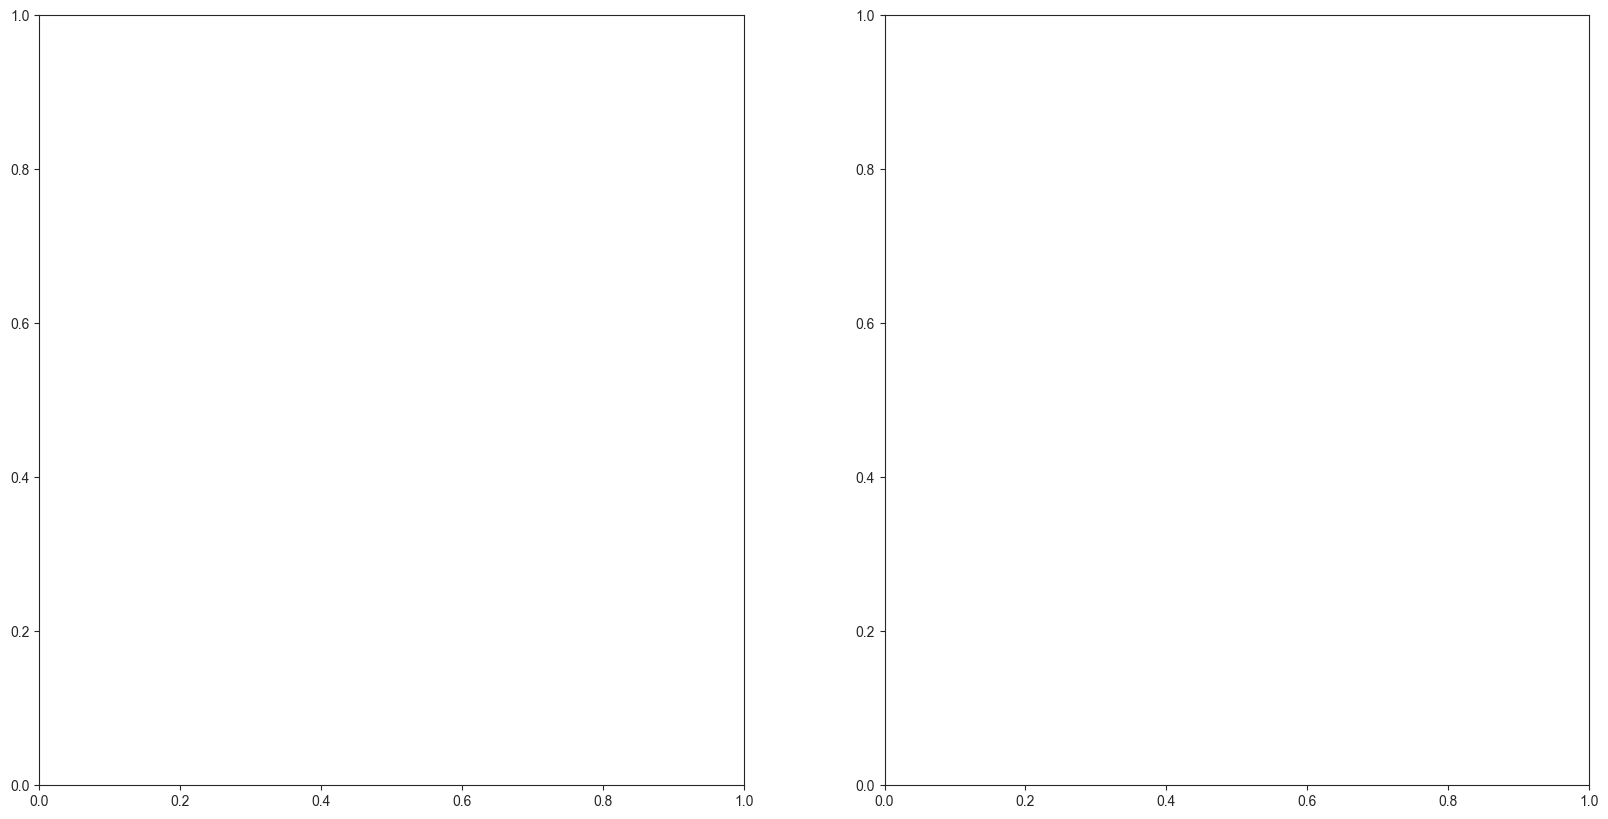

In [212]:
pca_components = pca.components_
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# First Principal Component
scatter1 = axes[0].scatter(Coordinates[:, 0], Coordinates[:, 1], c=pca.components_[0], cmap='viridis')
fig.colorbar(scatter1, ax=axes[0])
axes[0].set_title('First Principal Component Loadings')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')

# Second Principal Component
scatter2 = axes[1].scatter(Coordinates[:, 0], Coordinates[:, 1], c=pca.components_[1], cmap='viridis')
fig.colorbar(scatter2, ax=axes[1])
axes[1].set_title('Second Principal Component Loadings')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')

plt.show()


In [189]:
# Check the shapes of Spikes and Spikes.T
print("Shape of Spikes:", Spikes.shape)
print("Shape of Spikes.T:", Spikes.T.shape)
# Check the shape of pca_components
print("Shape of pca_components:", pca_components.shape)

Shape of Spikes: (5500, 4633)
Shape of Spikes.T: (4633, 5500)
Shape of pca_components: (2, 5500)


In [193]:
Spikes.shape[1]

4633

In [192]:
Spikes.T.shape

(4633, 5500)

In [198]:
# Check the shapes of Spikes and Spikes.T
print("Shape of Spikes:", Spikes.shape)
print("Shape of Spikes.T:", Spikes.T.shape)

# Perform PCA
pca = PCA(n_components=2)
pca.fit(Spikes)
pca_components = pca.components_

# Check the shape of pca_components
print("Shape of pca_components:", pca_components.shape)

Shape of Spikes: (5500, 4633)
Shape of Spikes.T: (4633, 5500)
Shape of pca_components: (2, 4633)


In [197]:
Coordinates[:, 0].shape

(4633,)

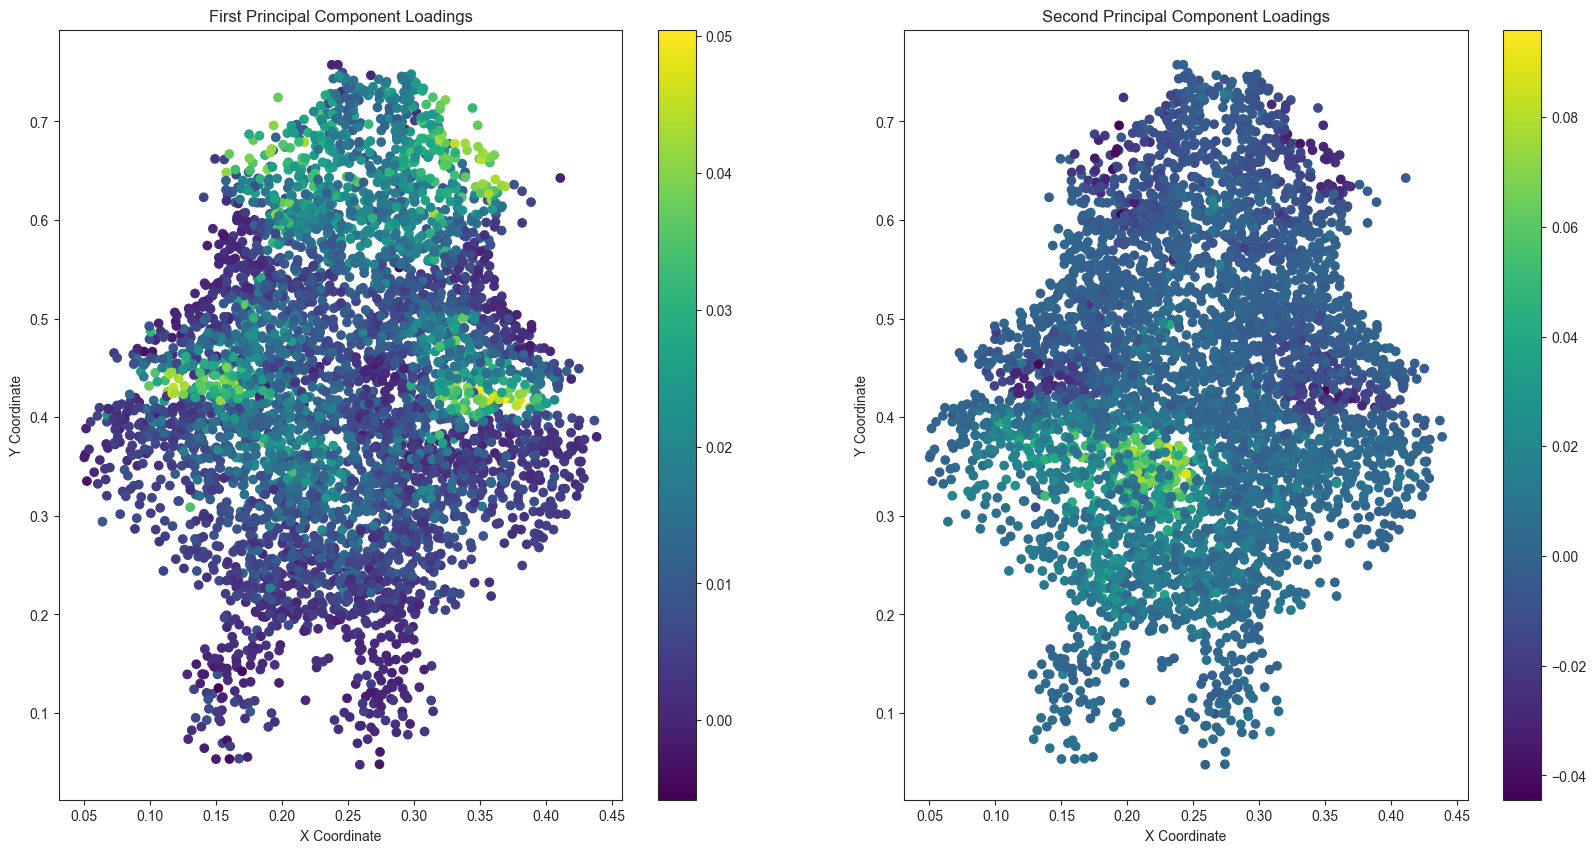

In [199]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Scatter plot for the first principal component
scatter1 = axes[0].scatter(Coordinates[:, 0], Coordinates[:, 1], c=pca_components[0], cmap='viridis')
fig.colorbar(scatter1, ax=axes[0])
axes[0].set_title('First Principal Component Loadings')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')

# Scatter plot for the second principal component
scatter2 = axes[1].scatter(Coordinates[:, 0], Coordinates[:, 1], c=pca_components[1], cmap='viridis')
fig.colorbar(scatter2, ax=axes[1])
axes[1].set_title('Second Principal Component Loadings')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')

plt.show()

Do they localize onto some of the morphological regions?

# 2. Using the scikit-learn’s implementation, apply Non-Negative Matrix Factorization with n_components=20 and visualize two components in space. Do they localize onto some of the morphological regions?

# 3. Repeat for n_components = 2, 5 and 50. How do the components change?
# 